In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lusee
import os
from scipy.interpolate import interp2d
from scipy.integrate import dblquad
import astropy.units as u

In [2]:
bf = os.path.join(os.environ['LUSEE_DRIVE_DIR'],"Simulations/BeamModels/LanderRegolithComparison/eight_layer_regolith/","hfss_lbl_3m_75deg.fits")
B = lusee.LBeam(bf)

In [59]:
Ptheta = [interp2d (B.theta, B.phi,((+np.abs(B.Etheta[fi,:,:]**2))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]
Pphi = [interp2d (B.theta, B.phi,(0.5*(+np.abs(B.Ephi[fi,:,:]**2))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]
PI = [interp2d (B.theta, B.phi,((np.abs(B.Etheta[fi,:,:]**2)+np.abs(B.Ephi[fi,:,:]**2))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]
PQ = [interp2d (B.theta, B.phi,((np.abs(B.Etheta[fi,:,:]**2)-np.abs(B.Ephi[fi,:,:]**2))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]
PU = [interp2d (B.theta, B.phi,((np.real(B.Etheta[fi,:,:]*np.conj(B.Ephi[fi,:,:])))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]
PV = [interp2d (B.theta, B.phi,((np.imag(B.Etheta[fi,:,:]*np.conj(B.Ephi[fi,:,:])))*B.gain_conv[fi]).T,bounds_error=True) for fi in np.arange(B.Nfreq)]

In [4]:
dblquad (lambda theta,phi:PI[20](theta,phi)*np.sin(theta), 0,2*np.pi, lambda x:0, lambda x:np.pi/2,epsabs=1e-3, epsrel=1e-3)[0]/(4*np.pi)

0.5029826149627746

In [5]:
B.sky_fraction()[20]

0.5029435829946828

In [6]:
def plotc(fp,N=100):
    x = np.outer(np.ones(N),np.linspace(-1,1,N))
    y = x.T
    r = np.sqrt(x**2+y**2)
    az = np.arctan2(x,y)
    alt = np.arccos(r)
    theta = np.pi/2-alt
    phi = np.pi/2-az
    phi[phi<0]+=2*np.pi
    img = [[fp(theta[i,j],phi[i,j]) for j in range(N)] for i in range(N)]
    return np.array(img)
    

    

/tmp/ipykernel_514/1633410499.py:6: RuntimeWarning: invalid value encountered in arccos
  alt = np.arccos(r)


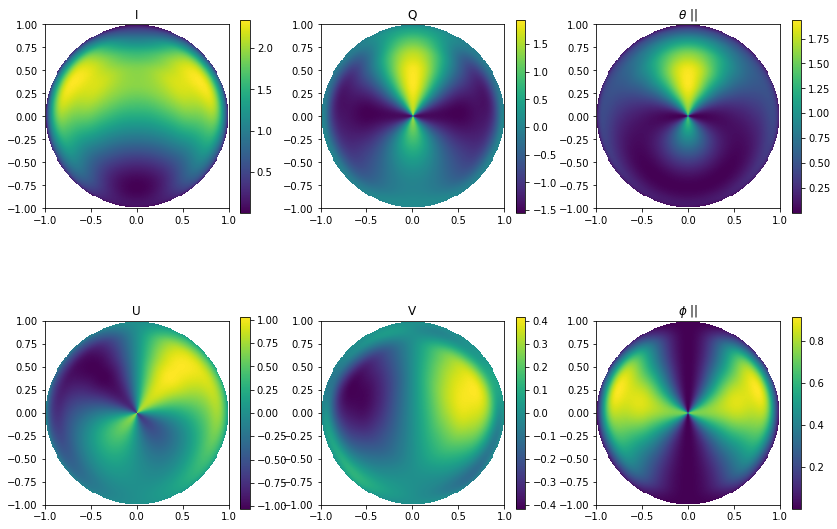

In [83]:
plt.figure(figsize=(14,10))
name = 'I','Q','$\\theta$ ||','U','V','$\\phi$ ||'
for e,P in enumerate([PI,PQ,Ptheta,PU,PV,Pphi]):
    plt.subplot(2,3,e+1)
    img = plotc (P[24],N=200)
    plt.imshow(img,origin='lower', extent=[-1,1,-1,1])
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(shrink=0.78)
    plt.title(name[e])


In [8]:
D=lusee.LData(os.path.join(os.environ['LUSEE_DRIVE_DIR'],"Simulations/PDR","hfss_lbl_3m_75deg_R10_CMB.fits"))
X=D[0,"00RV",0]*(lusee.monosky.T_NB(D.freq)/(2.73*u.K)).value+(4e-9)**2

In [18]:
def rec_power(theta,phi,PX,fi, Prec):
    lam = 3e8/(D.freq[fi]*1e6)
    return PX[fi](theta,phi)[0]*Prec*lam**2/(4*np.pi)/1.380649e-23*D.T2Vsq[0][fi]

def get_response(theta,phi, Prec):
    freq = D.freq
    V = np.array([rec_power(theta,phi,Pphi,fi,Prec) for fi in range(D.Nfreq)])
    return V

In [19]:
V=get_response (0.4,1,1e-22)

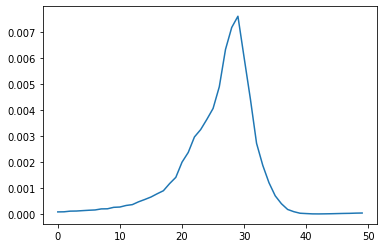

In [20]:
plt.plot(V/X)

/tmp/ipykernel_514/1633410499.py:6: RuntimeWarning: invalid value encountered in arccos
  alt = np.arccos(r)


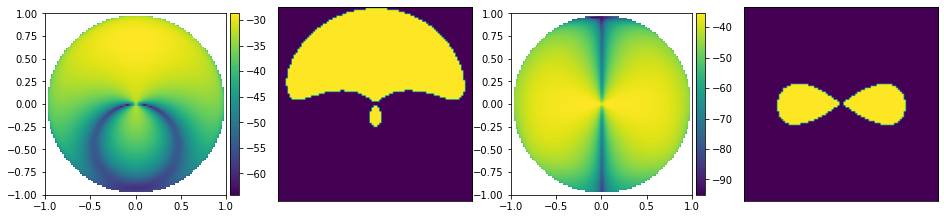

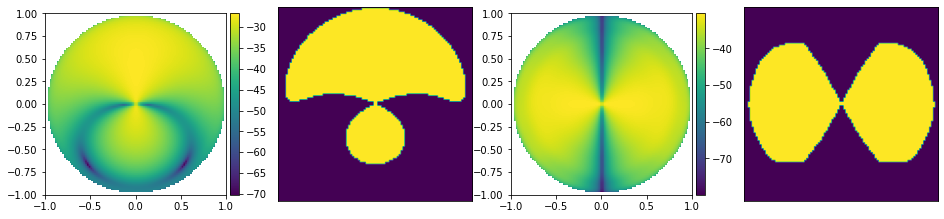

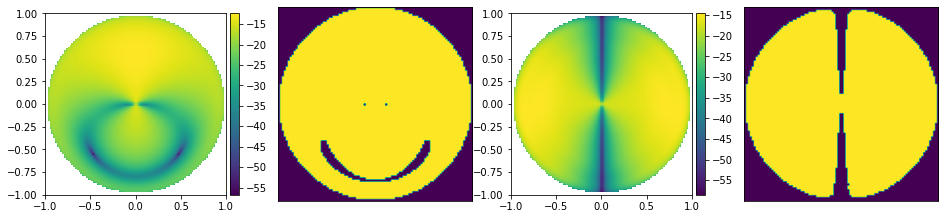

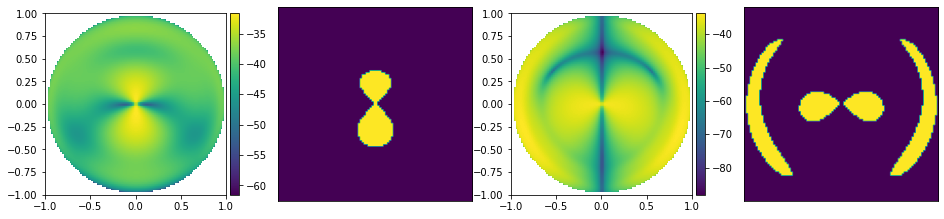

In [92]:
pwr=1e-22
from mpl_toolkits.axes_grid1 import make_axes_locatable
for fi in [0,9,29,49]:
    fig, ax = plt.subplots(1,4,figsize=(16,4))

    img=plotc(lambda theta,phi:10*np.log10(rec_power(theta,phi,Ptheta,fi,pwr)/X[fi]))
    t_ = ax[0].imshow(img,origin='lower',extent=(-1,1,-1,1))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(t_,cax=cax)
    ax[1].imshow(img>-35,origin='lower')
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)

    img=plotc(lambda theta,phi:10*np.log10(rec_power(theta,phi,Pphi,fi,pwr)/X[fi]))
    t_ = ax[2].imshow(img,origin='lower',extent=(-1,1,-1,1))
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(t_,cax=cax)
    ax[3].imshow(img>-37,origin='lower')
    ax[3].get_xaxis().set_visible(False)
    ax[3].get_yaxis().set_visible(False)
    